In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import magpylib as magpy
import matplotlib.pyplot as plt
import numpy as np
from magpylib_material_response import meshing, demag
from nn_magnetics.predictions import B
from nn_magnetics.utils import relative_amplitude_error, angle_error
from nn_magnetics.model import AngleAmpCorrectionNetwork

In [19]:
dimension = (1, 1, 1)
polarization = (0, 0, 1)
susceptibility = (0.1, 0.2, 0.3)
position = (0, 0, 0)

In [20]:
magnet = magpy.magnet.Cuboid(dimension=dimension, polarization=polarization, position=position)
magnet.susceptibility = susceptibility #type: ignore

In [21]:
mesh = meshing.mesh_Cuboid(magnet, target_elems=100)
demag.apply_demag(mesh, inplace=True)

2025-02-05 at 13:33:56 | SUCCESS  | timelog | {} ✅  Demagnetization (inplace) of Collection(id=5193423072) with 100 cells - Counter({'Cuboid': 100}) done 🕑 1.025sec


In [22]:
eps = 1e-8
a, b, c = dimension
axis_coarseness = 26

In [23]:
_grid = []
for xx in np.linspace(eps, a * 2.5, axis_coarseness):
    for yy in np.linspace(eps, b * 2.5, axis_coarseness):
        for zz in np.linspace(eps, 2.5, axis_coarseness):
            if not (
                0 <= xx <= a / 2 + eps
                and 0 <= yy <= b / 2 + eps
                and 0 <= zz <= 1 / 2 + eps
            ):
                _grid.append([xx, yy, zz])

grid = np.array(_grid)

In [24]:
B_true = mesh.getB(grid)

In [25]:
Bx, By, Bz = B_true.T

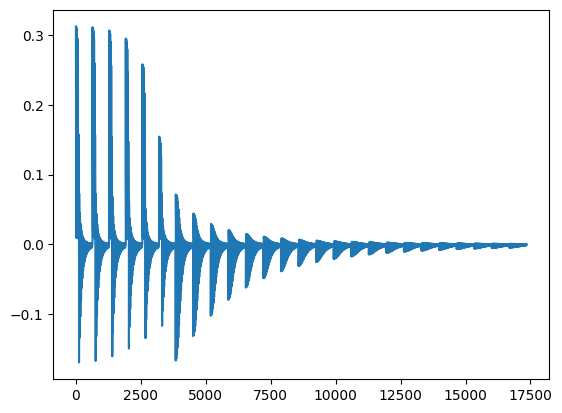

In [26]:
plt.plot(Bz)

In [97]:
B_prediction = B(
    position=np.array(position),
    dimension=np.array(dimension),
    polarization=np.array(polarization),
    susceptibility=np.array(susceptibility),
    points=grid,
    model_path="/Users/jacksmith/Documents/PhD/nn-magnetics/results/3dof_chi/2025-01-15 12:23:07.808007/best_weights.pt",
    network_type=AngleAmpCorrectionNetwork
)

In [98]:
B_prediction.shape

(17360, 3)

In [99]:
Bx_prediction, By_prediction, Bz_prediction = B_prediction.T

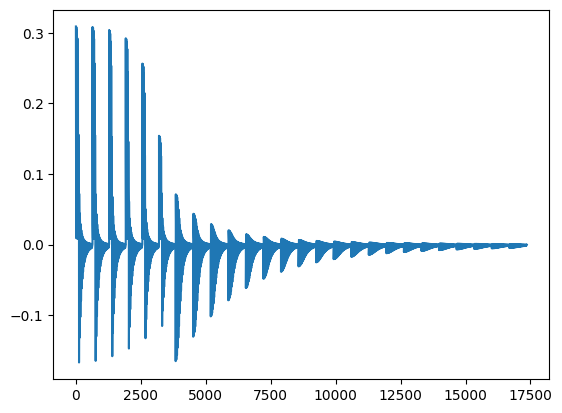

In [100]:
plt.plot(Bz_prediction)

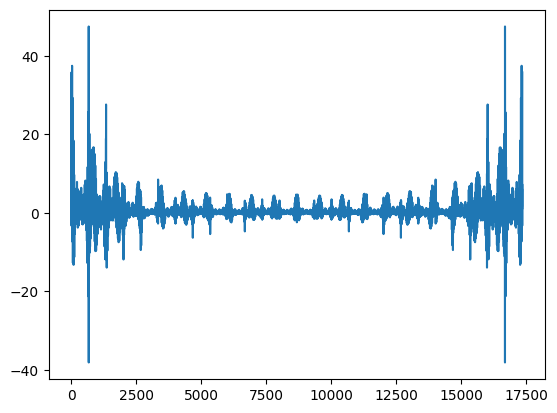

In [101]:
Bz_fft = np.fft.fft(Bz_prediction)
plt.plot(Bz_fft.real)

In [63]:
zero_crossings_idx = np.where(np.abs(Bz) < 5e-6)
zero_crossings_idx

(array([ 1245,  2445,  3832,  4971,  5131,  7213,  7836,  8273,  8976,
         9679,  9865, 10276, 10382, 10568, 10979, 11085, 11271, 11682,
        11788, 12385, 12438, 12491, 13088, 13141, 13194, 13501, 13791,
        13844, 13897, 14494, 14547, 14600, 14653, 15197, 15250, 15303,
        15531, 15636, 15715, 15900, 15953, 16006, 16025, 16051, 16418,
        16603, 16656, 16963, 17121, 17253, 17306, 17359]),)

In [102]:
amp_err = relative_amplitude_error(B_true, B_prediction, return_abs=False)
angle_err = angle_error(B_true, B_prediction)

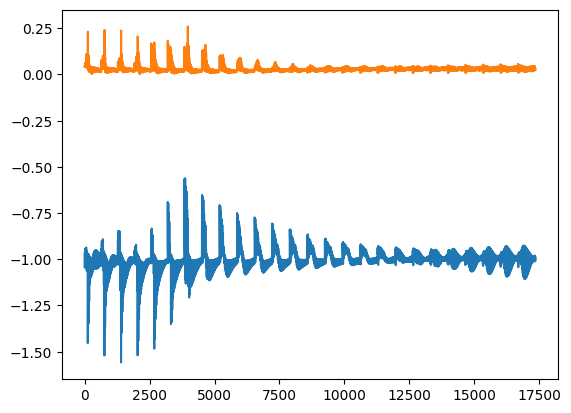

In [103]:
plt.plot(amp_err)
plt.plot(angle_err)
plt.show()

In [88]:
abs_error = B_true - B_prediction 
abs_error.shape

(17360, 3)

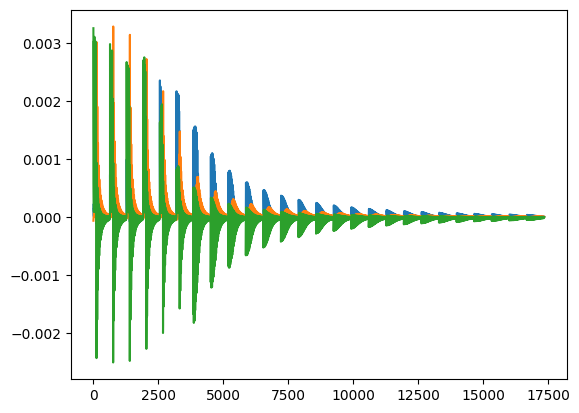

In [89]:
for component in abs_error.T:
    plt.plot(component, label="")